### Lab Machine Learning, part one: Heart disease prediction.
[Link Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)  
About the dataset:  
Features:  
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code | 1 = woman, 2 = man
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
- All of the dataset values were collected at the moment of medical examination.

Purpose:
- Find the most important risk factors for cardiovascular disease. This means that "cardio" is the response variable and the other features are explanatory variables. This is a classification problem.

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_orig = pd.read_csv('../data/cardio_train.csv', delimiter=";")

#### EDA

Examining the data, there is obviously some unrealistic data within it.
- Blood pressure: quite a lot of blood pressure metrics are unrealistic. Google search results in some knowledge on what values that are realistic to expect [Link to heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)
- Weight: there is some unrealistically low wight observations. Hard to draw a line but questimation is that values below 40kg can be removed.
- Height: mesures below 120cm and above 220cm removed. Obviously it's possible to be both taller and smaller, but this seems reasonable.

In [220]:
df = df_orig

1a: Number of individuals with presence and absence of cardiovascular disease.

In [221]:
cardio = df['cardio'].value_counts()
print(f'Nbr of individuels with absence of cardiovascular disease: {cardio.loc[0]}')
print(f'Nbr of individuels with presence of cardiovascular disease: {cardio.loc[1]}')

Nbr of individuels with absence of cardiovascular disease: 35021
Nbr of individuels with presence of cardiovascular disease: 34979


1b: Ratio of individuals with normal, above normal and well above normal cholesterol levels.

In [222]:
cholesterol_ratio = df['cholesterol'].value_counts()
cholesterol_ratio = cholesterol_ratio.to_frame()
cholesterol_ratio['cholesterol_ratio'] = cholesterol_ratio['count'] / cholesterol_ratio['count'].sum()
print(f'Ratio of individuals with "normal" cholesterol levels: {cholesterol_ratio.iloc[0,1]:.1%} percent')
print(f'Ratio of individuals with "above normal" cholesterol levels: {cholesterol_ratio.iloc[1,1]:.1%} percent')
print(f'Ratio of individuals with "well above normal" cholesterol levels: {cholesterol_ratio.iloc[2,1]:.1%} percent')


Ratio of individuals with "normal" cholesterol levels: 74.8% percent
Ratio of individuals with "above normal" cholesterol levels: 13.6% percent
Ratio of individuals with "well above normal" cholesterol levels: 11.5% percent


1c: Age distribution:

Age Data [years]: Mean=53.3, Stdev=6.8, Min=29.6, Max=65.0 


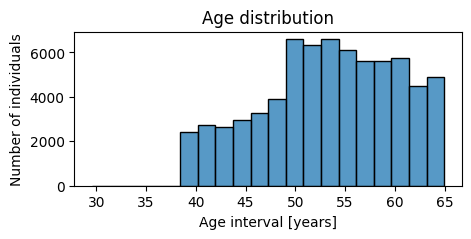

In [223]:
df.loc[:,'age_yrs'] = round(df.loc[:,'age']/365,2) # converting age in days into age in years
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data = df, x='age_yrs', bins=20), plt.title('Age distribution'), plt.ylabel('Number of individuals'), plt.xlabel('Age interval [years]')
print(f"Age Data [years]: Mean={df['age_yrs'].mean():.1f}, Stdev={df['age_yrs'].std():.1f}, Min={df['age_yrs'].min():.1f}, Max={df['age_yrs'].max():.1f} ")

1d: Ratio of smokers

In [224]:
ratio_smokers = df['smoke'][df['smoke'] == 1].sum() / len(df['smoke'])
print(f"Ratio of individuals that smoke: {ratio_smokers:.2%}")

Ratio of individuals that smoke: 8.81%


1e: Weight distribution.

Weight Data [kg]: Mean=74.21, Stdev=14.40, Min=10.00, Max=200.00 


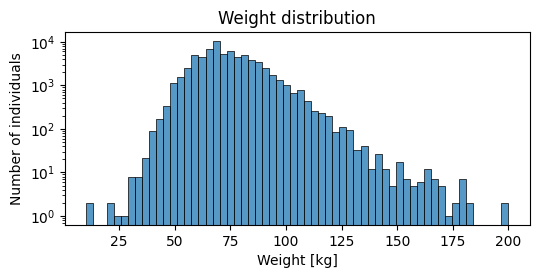

In [225]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.histplot(data=df, x='weight', bins=60), plt.title('Weight distribution'), plt.xlabel('Weight [kg]'), plt.ylabel('Number of individuals')
plt.yscale('log')
print(f"Weight Data [kg]: Mean={df['weight'].mean():.2f}, Stdev={df['weight'].std():.2f}, Min={df['weight'].min():.2f}, Max={df['weight'].max():.2f} ")

1f, length distribution:

Height Data [cm]: Mean=164.36, Stdev=8.21, Min=55.00, Max=250.00 


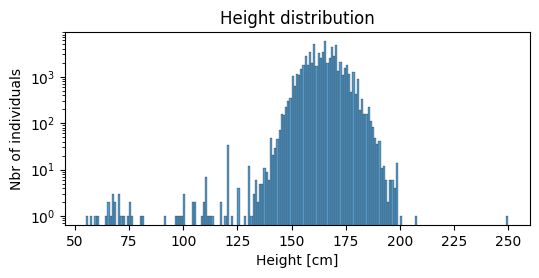

In [226]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.histplot(data=df, x='height', binwidth=1)
plt.title('Height distribution'), plt.xlabel('Height [cm]'), plt.ylabel('Nbr of individuals')
plt.yscale('log')
print(f"Height Data [cm]: Mean={df['height'].mean():.2f}, Stdev={df['height'].std():.2f}, Min={df['height'].min():.2f}, Max={df['height'].max():.2f} ")

1g: Ratio of cardivascular disease among men and women.

In [227]:
cardio_women = len(df[(df['gender'] == 1) & (df['cardio'] == 1)]) / len(df[(df['gender'] == 1)])
cardio_men = len(df[(df['gender'] == 2) & (df['cardio'] == 1)]) / len(df[(df['gender'] == 2)])
print(f'Cardiovascular disease among women = {cardio_women:.1%}, cardiovascular disease among men={cardio_men:.1%}')

Cardiovascular disease among women = 49.7%, cardiovascular disease among men=50.5%


ap_hi data [mmHg]: Mean=128.82, Stdev=154.01, Min=-150.00, Max=16020.00 
ap_lo data [mmHg]: Mean=96.63, Stdev=188.47, Min=-70.00, Max=11000.00 


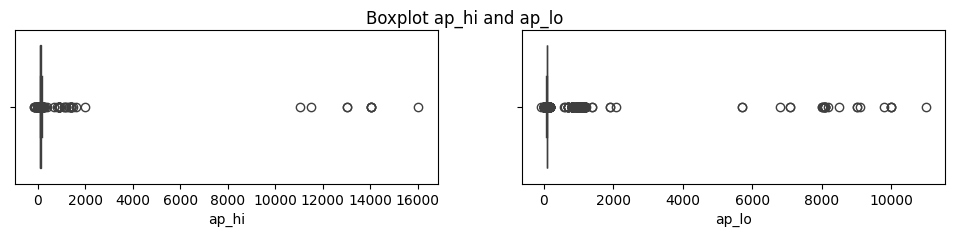

In [228]:
fig, ax = plt.subplots(1,2, figsize=(12,2))
plt.suptitle('Boxplot ap_hi and ap_lo')
sns.boxplot(data = df, x='ap_hi', ax=ax[0], orient='y')
sns.boxplot(data=df, x='ap_lo', ax=ax[1])
print(f"ap_hi data [mmHg]: Mean={df['ap_hi'].mean():.2f}, Stdev={df['ap_hi'].std():.2f}, Min={df['ap_hi'].min():.2f}, Max={df['ap_hi'].max():.2f} ")
print(f"ap_lo data [mmHg]: Mean={df['ap_lo'].mean():.2f}, Stdev={df['ap_lo'].std():.2f}, Min={df['ap_lo'].min():.2f}, Max={df['ap_lo'].max():.2f} ")

Correlation Matrix:

<Axes: >

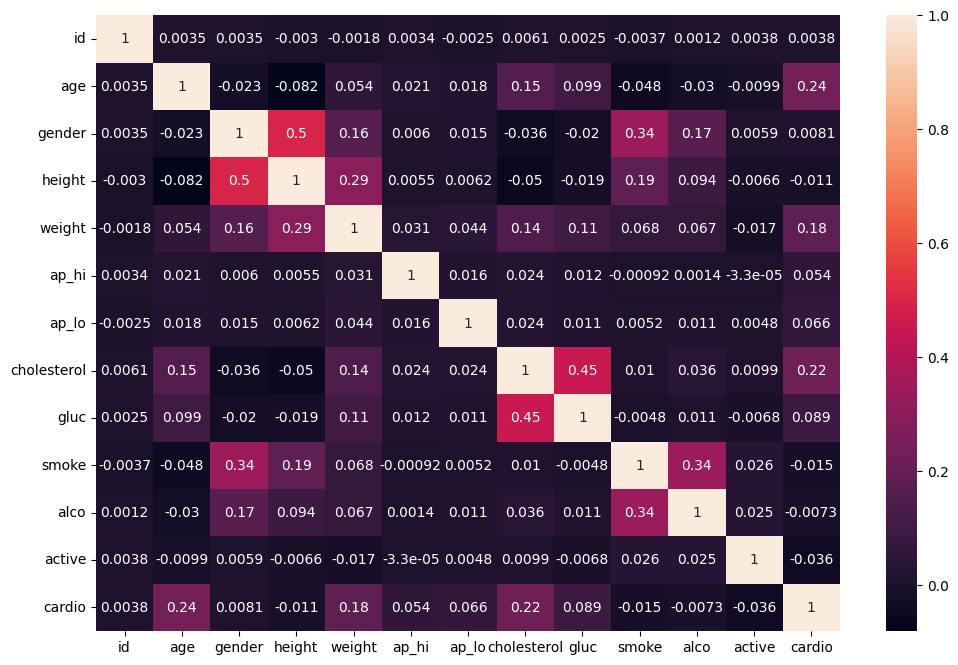

In [229]:
if 'age_yrs' in df.columns: df.drop(columns=['age_yrs'], inplace=True)
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_corr, annot=True)

In [230]:
# Listing top correlations between 'cardio' and the other features, in descending order.
a_corr = df_corr['cardio'].abs().sort_values(ascending=False)
print(a_corr[1:7])

age            0.238159
cholesterol    0.221147
weight         0.181660
gluc           0.089307
ap_lo          0.065719
ap_hi          0.054475
Name: cardio, dtype: float64


#### Summary of findings in EDA and correlation analysis:
- The data contains unrealistic values. E.g:
    - Weights in the magnitude of approx. 10-40 kg are not realistic.
    - Height in the magnitude of 55-130cm are not realistic. Height data of 250cm is probably also unrealistic, though possible.
    - Blood pressure data: there are unrealistic data that are either too low or even negative, as well as data that is way too high. The unit is mmHg, and my own basic knowledge is that values ranging from 60 to 140 is common among healthy individuals. High blood pressure is probably in the area of around 200+ mmHg.


- Original contains data that is unrealistic. An attempt has been made to removed the data that is unrealistic, but with a rather conservative approach in order to not remove valid data (probably there is still unrealistic data remaining). The removal of data has been done based on information found on internet (for blood pressure) and based on own experience (for weight and height). However, this can probably be fine tuned.
- Based on the correlation analysis, high blood pressure (ap_hi and ap_low) have the strongest correlation with 'cardio'. ap_hi and ap_lo are very much correlated as well (as expected).
- In descending order, the features with highest correlation to cardio are: api_hi, api_lo, age, cholesterol, weight and glucose.
- Height and gender is positvely correlated, meaning that men are taller than women.
- Smoking and gender is positively correlated (men are more prone to smoking).
- High glucose is not so correlated with cardio, but it is very mych correlated with cholesterol. Cholesterol in turn is relatively higly correlated with cardio.
- Weight and height have a positive correlation, meaning taller the individuals are generally heavier than short ones.
- The features gender, height, smoke, active and alco show very small correlation on cardio.
- Cardio is almost equally frequent among men and women.


### Feature engineering:
- Handle the unrealistic data in the dataset.
- Identify features to be included in analysis of 'cardio' risk factors.
#### Weight and Height
- Removing unrealistic data on weight and height, based on BMI. Involves the steps of calculating BMI for each individual. Theory from Wikipedia article used to define thresholds for removing data.
- Analysis of BMI in the dataset shows that BMI below the area of 14 is very "unlikely", they are very much outliers. At around BMI=14, the "bell curve" starts. Therefore, BMI<14 are removed.
- In the high end of BMI, no data is removed, beacuse it's realistic to weight 200+kg.
- Pruning: After above removing of samples based on BMI, an analysis shows that there are still samples in the dataset (on the low end) that could be considered 'strange', e.g. 28kg and 128 cm tall, which is very odd for adults. In an attempt to remove such data, decision is to remove samples that deviate more than 2.5 standard deviations from mean (on the low end only), for either height or weight. This means that samples with weight less than approximately 36kg and height less than 145 cm are removed.
#### Blood Pressure
- Blood pressure is measured in mmHg. The article states that ap_hi below 120 and ap_lo below 80 is healthy. ap_hi above 180 and ap_lo above 120 is hypertension crisis. The scale ends there, not stating what max level is realistic. Analysis of the data, in combination with information from the article, indicates that a good approximation should be to keep values for (50 < ap_hi < 250) and (40 < ap_lo < 200).

In [231]:
df['BMI'] = round(df['weight']/(df['height']/100)**2,2) #calculation of BMI, added to df
weight_info = df['weight'].describe() # creating an object that contains statistical data on weight
weight_low = weight_info['50%'] - 2.5 * weight_info['std'] # calculating the lower level of weight, values below to be removed
height_info = df['height'].describe() # creating an object that contains statistical data on height
height_low = height_info['50%'] - 2.5 * height_info['std'] # calculating the lower level of height, values below to be removed

In [233]:
df = df[(df['ap_lo'] < 200) & (df['ap_lo'] > 40) & (df['ap_hi'] > 50) & (df['ap_hi'] < 250) & (df['BMI'] >= 14) & (df['weight'] > weight_low) & (df['height'] > height_low)] #removing samples

height data: Mean=164.53, Stdev=7.72, Min=145.00, Max=207.00 
weight data: Mean=74.16, Stdev=14.25, Min=37.00, Max=200.00 
BMI data: Mean=27.43, Stdev=5.17, Min=14.48, Max=68.31 
ap_hi data: Mean=126.61, Stdev=16.75, Min=70.00, Max=240.00 
ap_lo data: Mean=81.40, Stdev=9.66, Min=45.00, Max=190.00 
Removing unrealistic data (due to BMI, height, weight and Blood Pressure) removed 1619 instances of the sampled data


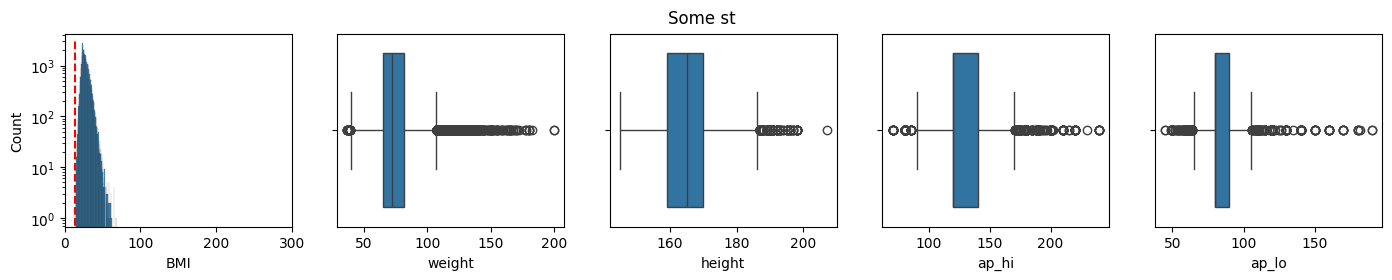

In [218]:
fig, ax = plt.subplots(1, 5, figsize=(17,2.5))
sns.histplot(data=df, x='BMI', cumulative=False, ax=ax[0])
fig.suptitle('Some st')
ax[0].set_xlim(right=300, left=0)
ax[0].set_yscale('log')
line_1 = plt.Line2D(xdata=[14,14], ydata=[0,3000], linestyle='--', color='red')
#line_2 = plt.Line2D(xdata=[200,200], ydata=[0,3000], linestyle='--', color='red')
ax[0].add_line(line_1)
#ax[0].add_line(line_2)
sns.boxplot(data=df, x='weight', ax=ax[1])
sns.boxplot(data=df, x='height', ax=ax[2])
sns.boxplot(data=df, x='ap_hi', ax=ax[3])
sns.boxplot(data=df, x='ap_lo', ax=ax[4])
for item in ['height','weight','BMI','ap_hi','ap_lo']:
    print(f"{item} data: Mean={df[item].mean():.2f}, Stdev={df[item].std():.2f}, Min={df[item].min():.2f}, Max={df[item].max():.2f} ")
print(f'Removing unrealistic data (due to BMI, height, weight and Blood Pressure) removed {len(df_orig)-len(df)} instances of the sampled data')

#### Creating categorical features on BMI and blood pressure.

In [234]:
df['BMI_class']=pd.cut(df['BMI'],bins=[0, 24.9, 29.9, 34.9, 39.9, 100], labels=['normal','overweight','obese class I','obese class II','obese class III'])
df['BP_class']=pd.cut(df['ap_hi'],bins=[0, 119.999, 129.99, 139.99, 179.99, 250], labels=['normal','elevated','high_stage_1','high_stage_2','high_crisis'])
df = pd.get_dummies(data= df, columns=['BMI_class','BP_class'], dtype=int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,BMI_class_normal,BMI_class_overweight,BMI_class_obese class I,BMI_class_obese class II,BMI_class_obese class III,BP_class_normal,BP_class_elevated,BP_class_high_stage_1,BP_class_high_stage_2,BP_class_high_crisis
0,0,18393,2,168,62.0,110,80,1,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,2,18857,1,165,64.0,130,70,3,1,0,...,1,0,0,0,0,0,0,1,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,4,17474,1,156,56.0,100,60,1,1,0,...,1,0,0,0,0,1,0,0,0,0


<Axes: >

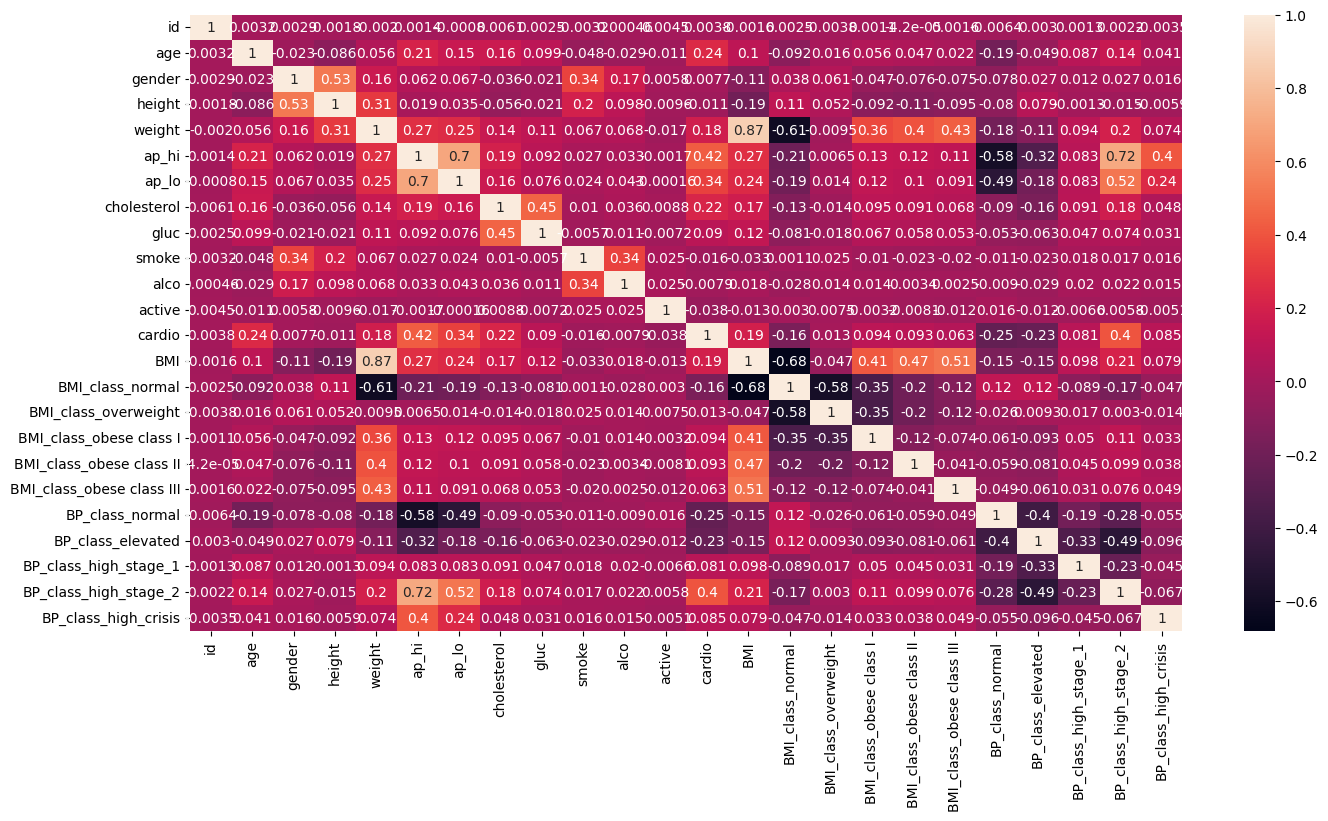

In [235]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df.corr(), annot=True)

In [236]:
df_corr = df.corr()
a_corr = df_corr['cardio'].abs().sort_values(ascending=False)
print(a_corr)

cardio                       1.000000
ap_hi                        0.424980
BP_class_high_stage_2        0.399634
ap_lo                        0.335712
BP_class_normal              0.249581
age                          0.239389
BP_class_elevated            0.232517
cholesterol                  0.221231
BMI                          0.191658
weight                       0.180549
BMI_class_normal             0.155193
BMI_class_obese class I      0.094461
BMI_class_obese class II     0.092543
gluc                         0.089521
BP_class_high_crisis         0.084954
BP_class_high_stage_1        0.081398
BMI_class_obese class III    0.063491
active                       0.037759
smoke                        0.016094
BMI_class_overweight         0.013490
height                       0.011280
alco                         0.007943
gender                       0.007740
id                           0.003773
Name: cardio, dtype: float64


In [237]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,BMI_class_normal,BMI_class_overweight,BMI_class_obese class I,BMI_class_obese class II,BMI_class_obese class III,BP_class_normal,BP_class_elevated,BP_class_high_stage_1,BP_class_high_stage_2,BP_class_high_crisis
0,0,18393,2,168,62.0,110,80,1,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,2,18857,1,165,64.0,130,70,3,1,0,...,1,0,0,0,0,0,0,1,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,4,17474,1,156,56.0,100,60,1,1,0,...,1,0,0,0,0,1,0,0,0,0


#### Conclusions feature engineering:
- In order of significance on 'cardio': blood pressure, age, cholesterol, wight/BMI, glucose.
- Features with low impact on 'cardio' are: gender, alco, height, smoke, active (surprisingly). Except for gender, these features are removed.
- Defining two dataframes with different features. The goal is to keep features that are highly correlated with 'cardio' but are not correlated to each other.
- df1 contains created categories rather than the original weight, height and blood pressure data.
- df2 contains the original data, rather than the created categories.

In [ ]:
df1 = df.drop(columns=['ap_hi','ap_lo','height','weight','BMI','alco','height','smoke','active'])
pd.get_dummies(df1, columns=['gender'], dtype=int, drop_first=True)

df2 = df.drop(columns=['ap_lo','BMI_class_normal', 'BMI_class_overweight', 'BMI_class_obese class I',
       'BMI_class_obese class II', 'BMI_class_obese class III',
       'BP_class_normal', 'BP_class_elevated', 'BP_class_high_stage_1',
       'BP_class_high_stage_2', 'BP_class_high_crisis','height','weight','alco','smoke','active'])
pd.get_dummies(df2, columns=['gender'], dtype=int, drop_first=True)

<Axes: >

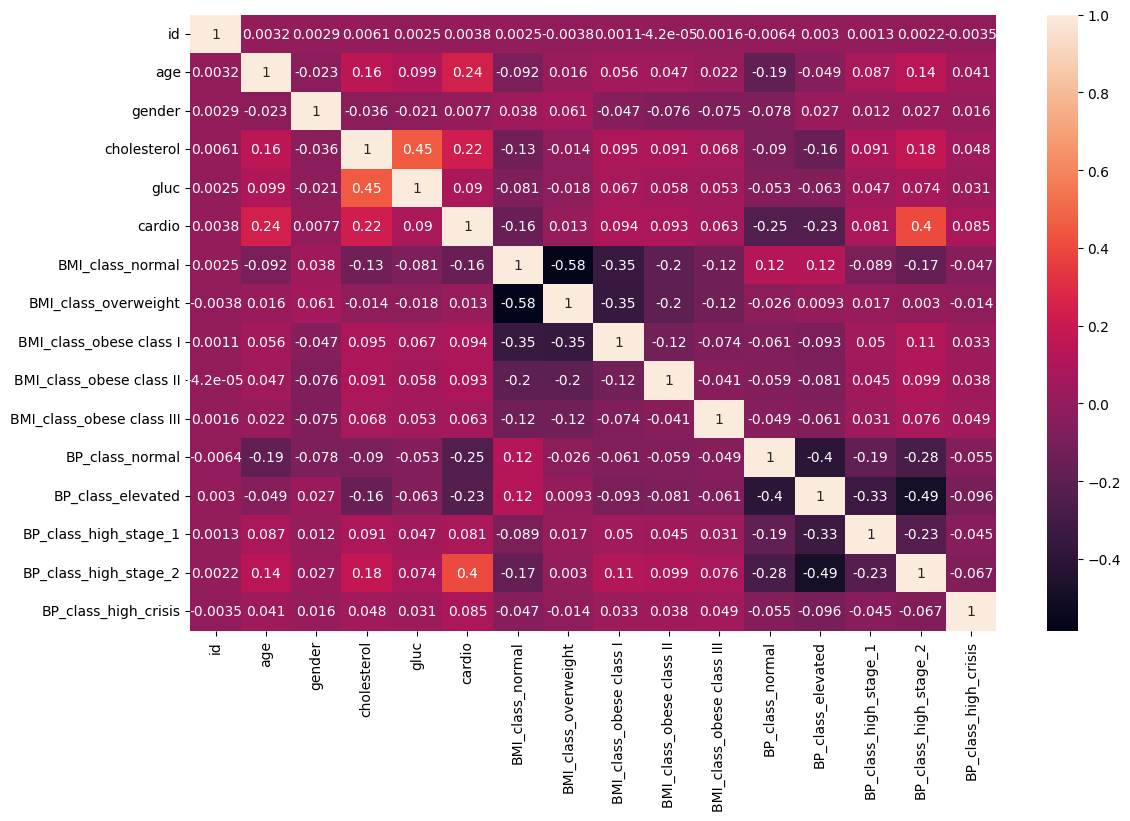

In [245]:
df1_corr = df1.corr()
df2_corr = df2.corr()
fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(df1_corr, annot=True)

#### Machine Learning
- Logistic Regression
- Random Forest
- KNN
- (Support Vector Machine)

In [246]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

pipe_log = Pipeline()